In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'read_nums_datasets',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

In [3]:
df_short = pd.read_csv(snakemake.input['short_counts'])
df_short['data source'] = 'rna-seq'

In [4]:
df_short = df_short.append({
    'type': 'polyA',
    'count': df_short[df_short['type'] == 'polyA']['count'].sum(),
    'data source': 'pseudo \n polyA-seq \n (gm12878)'
}, ignore_index=True)

In [5]:
df_quantseq = pd.read_csv(snakemake.input['quantseq'])
df_quantseq['data source'] = 'QuantSeq3 \n (gm12878)'

In [6]:
df_read3 = pd.read_csv(snakemake.input['read3'])
df_read3['data source'] = "3' READS \n (c2c12)"

In [7]:
df_c2c12 = pd.read_csv(snakemake.input['c2c12_read_annot'], sep='\t')

In [8]:
from collections import Counter

df_c2c12_long = pd.DataFrame({
    'type': ['raw'] * 4,
    'count': Counter(df_c2c12['dataset']).values(),
    'data source': 'long-read \n rna-seq \n (c2c12)'
})

In [9]:
df_pilot = pd.read_csv(snakemake.input['gm12878_read_annot'], sep='\t')
df_pilot = df_pilot[df_pilot['dataset'] == 'gm12878']

df_gm12878 = pd.DataFrame({
    'type': ['raw'],
    'count': [df_pilot.shape[0]],
    'data source': ['long-read \n rna-seq \n (gm12878)']
})

In [10]:
df = pd.concat([
    df_quantseq,
    df_read3,
    df_short,
    df_c2c12_long,
    df_gm12878
], axis=0).rename(columns={'type': 'read'}).replace({'raw': 'all', 'polyA': 'polyA-tailed'})

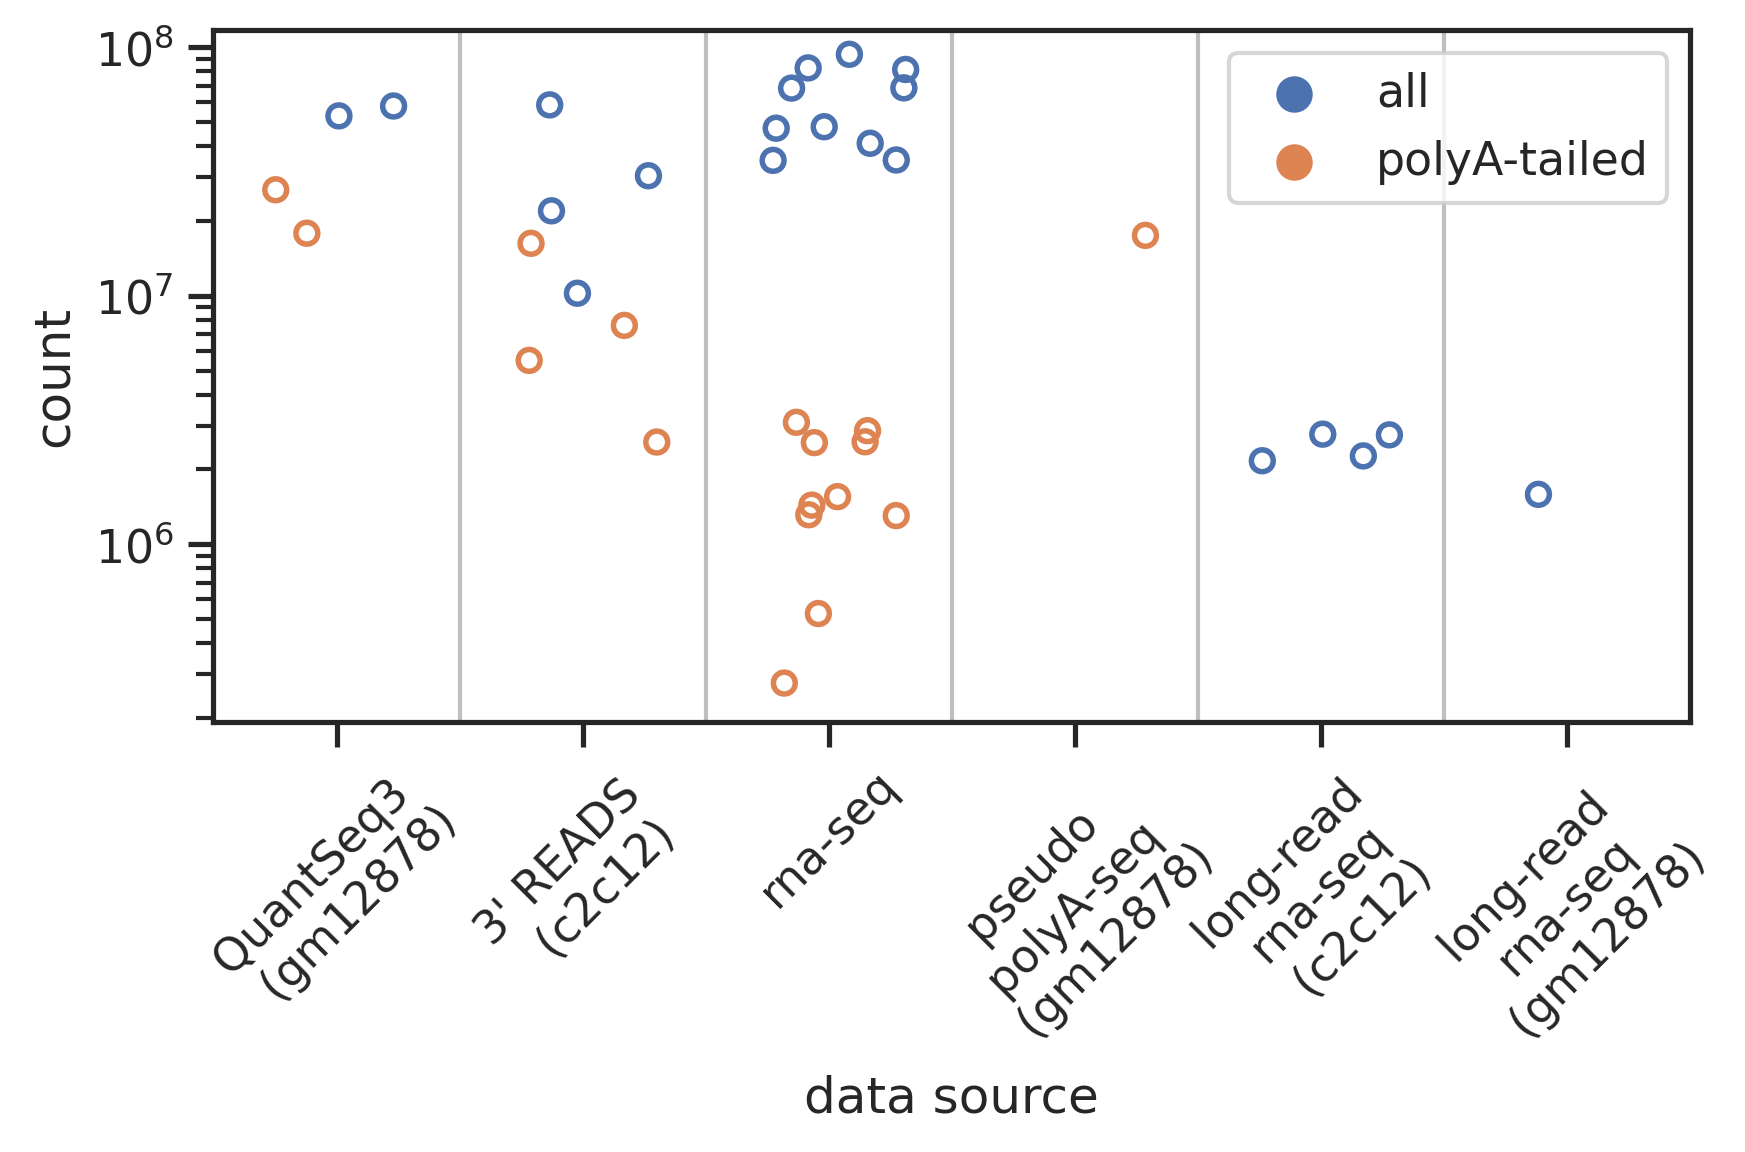

In [13]:
plt.figure(figsize=(6, 4), dpi=300)
ax = sns.stripplot(x='data source', y="count", hue="read", data=df, s=10, marker="$\circ$", jitter=0.3)
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='')
    
for i in range(len(set(df['data source'])) - 1):
    ax.axvline(i + 0.5, color='grey', lw=1, alpha=0.5)

plt.tight_layout()
plt.savefig(snakemake.output['read_nums'], bbox_inches = "tight")